In [26]:
# Importing the libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import plotly.express as px
import scipy.stats as ss
import seaborn as sns



### 0) Cargamos los datos desde respositorio Github y hecemos un breve análisis de las variables

In [27]:
# display
pd.options.display.float_format = '{:,.1f}'.format

# Cargamos el fichero desde el enlace web y creamos el dataframe
url = 'https://raw.githubusercontent.com/md-lorente/data/master/worlddometer_covid_ue.csv'

# Creacion Dataframe
df = pd.read_csv(url, sep=';', decimal='.', thousands=',',  encoding='utf-8')

# Ajustamos nombre de columna population
df.rename(index=str, columns={"Population ": "Population"}, inplace=True)

df['Total Cases'] = pd.to_numeric(df['Total Cases'], errors="raise",downcast= "float")

# Visualización del dataframe
df.head()

,Num,Country,Total Cases,New Cases,Total Deaths,New Deaths,Total Recovered,Active Cases,Serious Critical,Total Cases per 1M pop,Deaths per 1M pop,Total Tests,Tests per 1M pop,Population
0,0,Europe,"3,543,710.0","10,493.0","207,347.0",149.0,"2,063,335.0","1,273,028.0","5,619.0",NaN,NaN,NaN,NaN,NaN
1,1,Russia,"990,326.0",498.0,"17,093.0",68.0,"806,982.0","166,251.0",23.0,"6,786.0",117.0,"36,400,000.0","249,409.0","145,944,843.0"
2,2,Spain,"455,621.0",NaN,"29,011.0",NaN,NaN,NaN,751.0,"9,744.0",620.0,"8,517,446.0","182,161.0","46,757,783.0"
3,3,UK,"332,752.0",NaN,"41,498.0",NaN,NaN,NaN,60.0,"4,897.0",611.0,"16,273,209.0","239,508.0","67,944,393.0"
4,4,France,"272,530.0",NaN,"30,602.0",NaN,"86,177.0","155,751.0",387.0,"4,174.0",469.0,"6,175,223.0","94,571.0","65,297,356.0"


#### Realizamos una primera inspección del dataframe, donde constatamos que tenemos 14 variables y 49 observaciones.

In [28]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 49 entries, 0 to 48
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Num                     49 non-null     int64  
 1   Country                 49 non-null     object 
 2   Total Cases             49 non-null     float32
 3   New Cases               17 non-null     float64
 4   Total Deaths            46 non-null     float64
 5   New Deaths              7 non-null      float64
 6   Total Recovered         45 non-null     float64
 7   Active Cases            45 non-null     float64
 8   Serious Critical        37 non-null     float64
 9   Total Cases per 1M pop  48 non-null     float64
 10  Deaths per 1M pop       45 non-null     float64
 11  Total Tests             47 non-null     float64
 12  Tests per 1M pop        47 non-null     float64
 13  Population              48 non-null     float64
dtypes: float32(1), float64(11), int64(1), object(1)
m

#### Calidad de los datos ####

En el dataset hay algunas columnas con valores missing. Hay ocasiones en que es necesario eliminar estas observaciones con dropna() o imputar los valores con las medias de cada variable, pero como no las vamos a utilizar en el análisis, es que no las intervenimos.

Para efectos del análisis probabilístico, trabajaremos con las variables Country, Total Cases, Total Deaths y Population, las cuales tienen todos sus valores.

In [29]:
df_nulos = df.isna().sum()
df_nulos

Num                        0
Country                    0
Total Cases                0
New Cases                 32
Total Deaths               3
New Deaths                42
Total Recovered            4
Active Cases               4
Serious Critical          12
Total Cases per 1M pop     1
Deaths per 1M pop          4
Total Tests                2
Tests per 1M pop           2
Population                 1
dtype: int64

#### Para tener un panorama global del tipo de datos, es que identificamos la tipología de las variables ####
**Country**: Cualitativa nominal, la cual, en función del análisis de datos sería clasificatoria. Todo el resto (**Total Cases**, **New cases**,**Total Deaths**, **New Deaths**, **Total recovered**, **Active Cases**, **Seriuos Critical**, **Total cases per 1M pop**, **Deaths per 1M pop**,**Total Test**, **Test per 1M pop** y **Population**) se trata de variables cuantitativas discretas, porque estamos contando personas. En función del análisis de datos serían analíticas. 

#### Seleccionamos 6 países sobre los cuales haremos el análisis.

In [30]:
# filtramos estos 6 paises
df2 = df.sort_values(by='Total Cases', ascending=False)
df2 = df2[df2['Country'].isin(['Spain','UK','France','Italy','Germany','Ukraine'])]
df2

,Num,Country,Total Cases,New Cases,Total Deaths,New Deaths,Total Recovered,Active Cases,Serious Critical,Total Cases per 1M pop,Deaths per 1M pop,Total Tests,Tests per 1M pop,Population
2,2,Spain,"455,621.0",NaN,"29,011.0",NaN,NaN,NaN,751.0,"9,744.0",620.0,"8,517,446.0","182,161.0","46,757,783.0"
3,3,UK,"332,752.0",NaN,"41,498.0",NaN,NaN,NaN,60.0,"4,897.0",611.0,"16,273,209.0","239,508.0","67,944,393.0"
4,4,France,"272,530.0",NaN,"30,602.0",NaN,"86,177.0","155,751.0",387.0,"4,174.0",469.0,"6,175,223.0","94,571.0","65,297,356.0"
5,5,Italy,"266,853.0",NaN,"35,473.0",NaN,"208,224.0","23,156.0",79.0,"4,415.0",587.0,"8,509,618.0","140,778.0","60,447,003.0"
6,6,Germany,"242,825.0",NaN,"9,363.0",NaN,"217,484.0","15,978.0",245.0,"2,897.0",112.0,"11,208,091.0","133,703.0","83,828,051.0"
7,7,Ukraine,"119,074.0","2,096.0","2,527.0",35.0,"56,734.0","59,813.0",177.0,"2,725.0",58.0,"1,536,171.0","35,161.0","43,689,434.0"


### **Contexto** 
#### Realizamos un breve análisis de las medidas adoptadas por estos 6 países europeos, para tener un contexto global que nos permita analizar los resultados.  


El presente análisis presenta un breve resumen sobre algunas medidas adoptadas por los países europeos conformados por Alemania, España, Francia, Italia, Reino Unido y Ucrania. La primera tabla busca resumir las medidas básicas tomadas por los países europeos, teniendo en cuenta que este cubre las medidas hasta el 31 de julio de 2020. La segunda tabla busca resumir las medidas adoptadas despues del 31 de julio hasta el dia 29-08-2020. La información se rescató de distintas revistas reconocidas como *BBC*, *FranceNews*, *El país*, fuentes oficiales de los gobiernos de paises europeos.



#### **a. Medidas de contención adoptadas por los gobiernos europeos (enero-julio 2020)**

|Paises|Estado de Emergencia|Cuarentena|Toque de queda|Cierre de fronteras|
|------|--------------------|----------|--------------|-------------------|
|Alemania|No se declaro|No se impuso|No se impuso|14/03/20 - 02/07/20|
|España|14/03/20 - 21/06/20|14/03/20 - 17/07/20|No se impuso|17/03/20 - 01/07/20|
|Francia|21/03/20 - 10/07/20|17/03/20 - 02/05/20|No se impuso|17/03/20 - 01/07/20|
|Italia|31/01/20 - 15/09/20|09/03/20 - 03/07/20|No se impuso|17/03/20 - 01/07/20|
|Reino Unido|23/03/2020 - |23/03/20 - 04/07/20|No se impuso|No se cerraron|
|Ucrania|25/03/2020 - |06/04/20 - 22/05/20|No se impuso|16/03/20 - 15/06/20|


#### **b. Medidas de contención adoptadas por los gobiernos europeos (Julio - Septiembre)**

Estas son algunas medidas de contención que los gobiernos europeos impusieron a sus ciudadanos para controlar los contagios de COVID-19.

* **Reino Unido:**

 * Restaurantes y pubs no podrán permanecer abiertos más allá de las 10:00 pm y solamente podrán ofrecer servicio de mesa.
 * La asistencia a bodas se limitará a un máximo de 15 personas y ya no habrá excepciones para deportes practicados bajo techo.
 * El uso de mascarillas pasa a ser obligatorio para los empleados del sector de la hostelería y el comercio minorista, además de para pasajeros de taxis y similares.
 *La multa por no usar una máscara o romper "la regla de los seis", por ejemplo, se duplicará para llegar a £200 (US.$250$) para la primera falta.
 *Multas de £10.000 (US$12.800) impuestas a quienes incumplen la orden de ponerse en cuarentena ahora también se aplicarán a las empresas.
 *reuniones de máximo 6 personas de diferentes hogares en interiores o exteriores.

* **España:** 

  * En cuanto al funcionamiento de los restaurantes, el Gobierno señaló que el número máximo de comensales por mesa será de 10 y que el horario irá solo hasta la 1:00 a.m.
  * El botellón está prohibido. No se puede tomar alcohol en la vía pública. Se insta a los ayuntamientos a aplicar el régimen sancionador de forma estricta.
  * los controles de acceso a las residencias de adultos mayores y limitadas las visitas a una sola persona por residente. 
  * la prohibición de fumar al aire libre si no es posible respetar la distancia de seguridad mínima estipulada por el Ministerio de Sanidad, que es de al menos dos metros entre ciudadanos. 
  *El uso de mascarilla es una medida básica, y su uso es obligatorio en varios territorios. 

* **Francia:** 

  * Mascarillas en todos los lugares públicos.
  * Las concentraciones de más de 5.000 personas, prohibidas hasta octubre.
  *prohibieron las fiestas de estudiantes y se suspendieron los viajes escolares

* **Italia:**

  * Los bares y restaurantes pueden abrir de las 06:00 a las 18:00 deben garantizar una distancia de al menos un metro entre clientes.
  * prohibido las reuniones públicas, incluyendo bodas, bautizos y funerales.
  *medidas de "distanciamiento social"
  *sanciones penales para quien viola la obligación de la cuarentena.

* **Alemania:**

  * Las grandes reuniones públicas, incluidos los servicios religiosos, permanecerán prohibidas hasta el 31 de agosto. Los bares, cafeterías, restaurantes, cines y locales de música permanecerán cerrados.
  *Las personas a usar máscaras faciales cuando salieran de compras o en el transporte público pero no es obligatorio.
  *como norma general, la distancia interpersonal de 1,5 metros.

* **Ucrania:**

  * La Resolución N° 211 establece que en todos los lugares públicos se debe portar mascarilla o respirador.
  *El Gobierno no cierra las iglesias, pero las reuniones masivas y religiosas están prohibidas.
  *Los ciudadanos deben reunirse únicamente en grupos de dos en las calles. Una excepción es el acompañamiento de niños independientemente de su número.
  *La Resolución No. 211 establece que los niños no pueden estar en lugares públicos sin adultos. Se recomienda que los niños no salgan de casa sin un adulto.
  *Quedan prohibidas las visitas a parques, jardines públicos, zonas de recreo, parques forestales y zonas costeras. Esto solo está permitido si se necesita pasear una mascota o en caso de exigencia laboral.

#### **c. Pirámide de Población (2020)**
Consideramos que otro elemento importante a considerar, es la distribución etaria de la población de estos países. Para ello hemos utilizado gráficos de https://www.populationpyramid.net/, que utiliza como principal fuente de información, datos demográficos de Naciones Unidas.

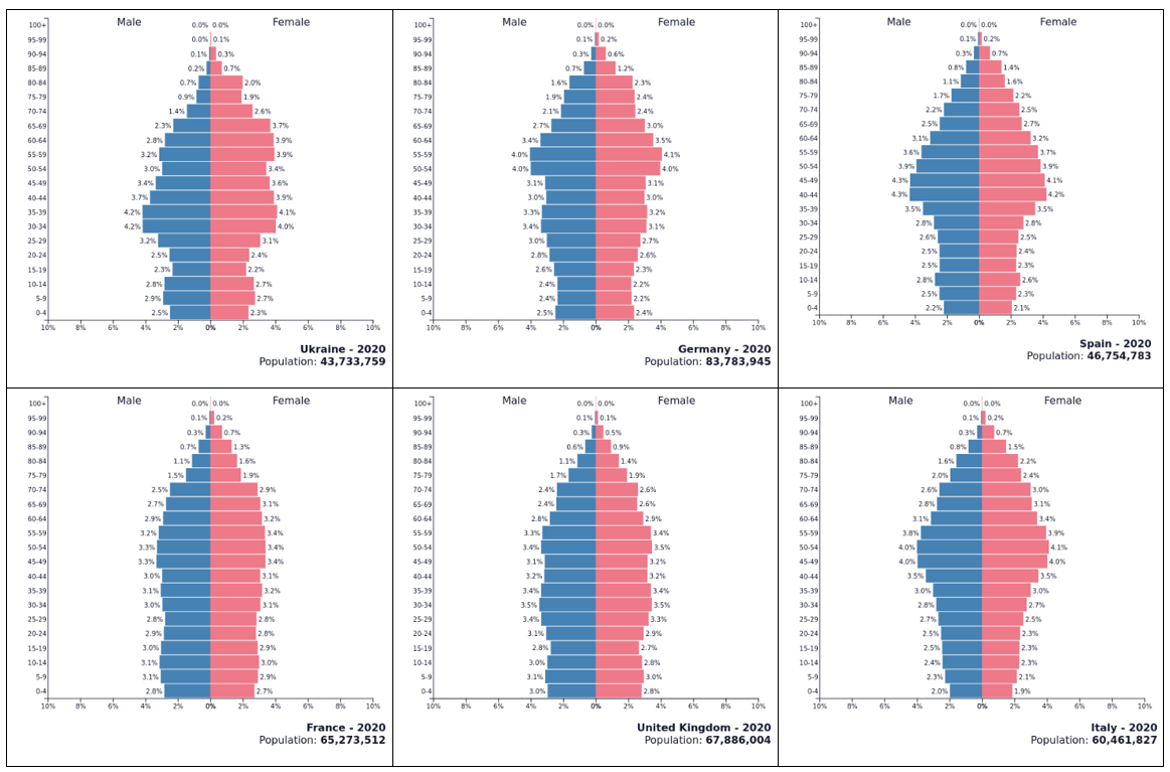



Aquí todo indica que un posible factor en el buen desempeño de Ukrania, respecto de los otros 5 países, es la juventud y asimetría de su población, concentrada alrededor de los 35 años y con mas mujeres que hombres. En el otro extremo del desempeño está Italia, con una población mayor, concentrada alrededor de los 50 años y muchos ancianos.

### 1.	La probabilidad de sobrevivir en cualquiera de los seis países europeos seleccionados para el estudio.

Si definimos la probabilidad de fallecer en cada país como el cociente del total de fallecidos entre el total de casos, entonces la probabilidad de sobrevivir será 1 - probabilidad de fallecer. 

Esto lo resolvemos aplicando Laplace. 

$$\frac{casos \_ favorables}{casos \_ posibles} = \frac{Total \_ Deaths}{Total \_ Cases}$$

Luego aplicamos la fórmula en el dataset 

In [31]:
pd.options.display.float_format = '{:,.2f}'.format
df3 = df2[['Country','Total Cases', 'Total Deaths']].copy(deep=True)
df3['probabilidad de morir %'] = df3.apply(lambda x: 100*(x['Total Deaths']/x['Total Cases']), axis=1)
df3['probabilidad de sobrevivir %'] = df3.apply(lambda x: 100-x['probabilidad de morir %'], axis=1)
df3

,Country,Total Cases,Total Deaths,probabilidad de morir %,probabilidad de sobrevivir %
2,Spain,"455,621.00","29,011.00",6.37,93.63
3,UK,"332,752.00","41,498.00",12.47,87.53
4,France,"272,530.00","30,602.00",11.23,88.77
5,Italy,"266,853.00","35,473.00",13.29,86.71
6,Germany,"242,825.00","9,363.00",3.86,96.14
7,Ukraine,"119,074.00","2,527.00",2.12,97.88


Podemos observar que el país con el mejor desempeño es Ukrania, con una altísima probabilidad de sobrevivir 97.9%.  Italia ocupa el extremo opuesto con un 86.7%. España está sobre la mediana. 

### 2.	Si seleccionamos una de las personas fallecidas, ¿cuál es la probabilidad de que residiera en España? ¿Y en el resto de países? 

Vamos a aplicar dos metodologías para llegar al mismo resultado:

**a) Probabilidad condicional**. Aquí la idea es encontrar la probabilidad de A dado B, donde A es la probabilidad de residir en España y B es el hecho cierto de haber fallecido de Covid.

Nuestro espacio muestral son estos 6 países: España, UK, Francia, Italia, Alemania y Ukrania.

El suceso A es ser residente en un país determinado, por ejemplo España, y le llamaremos **"esp"** y al suceso B, fallecido, le llamaremos **"fdo"**.

Luego, 

$P(esp|fdo)$ es la probabilidad condicional de que la persona seleccionada residiera en España dada la certeza que ha fallecido.

Aplicando la fórmula de probabilidad condicional: 

$P(esp|fdo) =  \frac{P(esp ∩ fdo)}{P(fdo)}$

Donde:

$P(esp ∩ fdo)$: Probabilidad de que el ciudadano seleccionado sea residente en Espana y fallecido de Covid. Se calcula como el cociente de la intersección (fallecidos residentes en España) entre la población total de estos 6 países.

$P(esp ∩ fdo) = \frac{29,011}{367,964,020}$

y:

$P(fdo)$: Probabilidad de que la persona seleccionada haya fallecido de Covid, se calcula como el cociente del total de fallecidos entre la población total de estos 6 países.

$P(fdo) =  \frac{148,474}{367,964,020}$

Luego:

$P(esp|fdo) =  \frac{\frac{29,011}{367,964,020}}{\frac{148,474}{367,964,020}} = \frac{29,011}{148,474} = 0.19539$

Lo que en términos porcentuales sería **19.539%**

Usamos el mismo procedimiento para calcular el resto de los países.

In [32]:
# despliegue de decimales por default 
pd.options.display.float_format = '{:,.5f}'.format
# creamos dataframe con columnas Country, Total Deaths y Population
df4 = df[['Country','Total Deaths','Population' ]].copy(deep=True)
df4 = df4[df4['Country'].isin(['Spain','UK','France','Italy','Germany','Ukraine'])]
# total de fallecidos en estos 6 países
def_total = df4['Total Deaths'].sum()
df4['def_total'] = def_total
# probabilidad de haber fallecido dado que es residente de un país
df4['prob condicional'] = df4.apply( lambda x: x['Total Deaths']/x['def_total'], axis=1 ) 
df4

,Country,Total Deaths,Population,def_total,prob condicional
2,Spain,"29,011.00000","46,757,783.00000","148,474.00000",0.19539
3,UK,"41,498.00000","67,944,393.00000","148,474.00000",0.27950
4,France,"30,602.00000","65,297,356.00000","148,474.00000",0.20611
5,Italy,"35,473.00000","60,447,003.00000","148,474.00000",0.23892
6,Germany,"9,363.00000","83,828,051.00000","148,474.00000",0.06306
7,Ukraine,"2,527.00000","43,689,434.00000","148,474.00000",0.01702


**b) Teorema de Bayes**: Ahora vamos a calcular la probabilidad condicional de $P(A_{i}|B)$ a partir de las probabilidades condicionales de $P(B|A_{i})$. 

El Teorema de Bayes nos indica que la probabilidad del suceso $P(A_{i}|B)$ se calcula de la siguiente forma:

$ 
P(A_{i}|B) = \frac{ P(A_{i}) \cdot P(B|A_{i}) }{ \sum_{j=1}^n P(A_{j}) \cdot P(B|A_{j})}  \quad \text{siendo} \quad i = 1,2, \ldots , n
$

Luego, si al suceso residente en España le llamamos **"esp"** y al suceso fallecido le llamamos **"fdo"**, obtenemos:   

$ 
P(esp|fdo) = \frac{ P(esp) \cdot P(fdo|esp) }{P(fdo)} 
$ 

Donde $P(esp|fdo)$ es la probabilidad condicional de que la persona seleccionada residiera en España dado que ha fallecido de Covid y $P(fdo|esp)$
es la probabilidad condicional de que la persona seleccionada haya fallecido dado que residía en España.

$P(fdo)$ es la probabilidad de total de haber fallecido, y por **Teorema de la Probabilidad Total** se puede descomponer en: 

$
P(fdo) = P(esp) \cdot P(fdo|esp) + P(gbr) \cdot P(fdo|gbr) + P(fra) \cdot P(fdo|fra) + P(ita) \cdot P(fdo|ita) + P(deu) \cdot P(fdo|deu) + P(ukr) \cdot P(fdo|ukr)
$

Por lo tanto, la "**probabilidad a priori**", probabilidad de que la persona sea residente en España, será el cociente de la población total de España entre la población total de estos 6 países:

$P(esp) = \frac{46,757,783}{367,964,020} = 0.127$

La probabilidad condicional que la persona seleccionada haya fallecido dada la certeza que residía en España, será el cociente de la intersección(fallecidos residentes en España) entre la población total de España:

$P(fdo|esp) = \frac{29,011}{46,757,783} = 0.00062$

y

$P(esp) \cdot P(fdo|esp) = 0.127 \cdot \frac{29,011}{46,757,783} = 0.000079$

Hacemos el mismo procedimiento con los otros 5 países:

$P(gbr) \cdot P(fdo|gbr) = 0.185 \cdot \frac{41,498}{46,757,783} = 0.000113$<br>
$P(fra) \cdot P(fdo|fra) = 0.177 \cdot \frac{30,602}{46,757,783} = 0.000083$<br>
$P(ita) \cdot P(fdo|ita) = 0.164 \cdot \frac{35,473}{46,757,783} = 0.000096$<br>
$P(deu) \cdot P(fdo|deu) = 0.228 \cdot \frac{9,363}{46,757,783} = 0.000025$<br>
$P(ukr) \cdot P(fdo|ukr) = 0.119 \cdot \frac{2,527}{46,757,783} = 0.000007$<br>

Esto nos da una probabilidad total $P(fdo)$ de $0.000404$ 

Finalmente obtenemos $P(esp|fdo)$ ó **"probabilidad a posteriori"**:

$ 
P(esp|fdo) = \frac{ P(esp) \cdot P(fdo|esp) }{P(fdo)} 
$ 

$
P(esp|fdo) = \frac{0.127 \cdot 0.00062}{0.000404} = \frac{0.000079}{0.000404}=0.19539 
$

Lo que en términos porcentuales sería **19.539%**, mismo resultado obtenido en punto **a**. 



Este problema, resuelto por Teorema de Bayes y aplicado al dataset se vería así:

In [33]:
# despliegue de decimales por default 
pd.options.display.float_format = '{:,.5f}'.format
# creamos dataframe con columnas Country, Total Deaths y Population
df5 = df[['Country','Total Deaths','Population' ]].copy(deep=True)
df5 = df5[df5['Country'].isin(['Spain','UK','France','Italy','Germany','Ukraine'])]
# total de la población en estos 6 países
pop_total = df5['Population'].sum()
# total de fallecidos en estos 6 países
def_total = df5['Total Deaths'].sum()
df5['pop_total'] = pop_total
df5['def_total'] = def_total
# probabilidad de ser residente de un país determinado
df5['prob a priori'] = df5.apply( lambda x: x['Population']/pop_total, axis=1 )
# probabilidad de haber fallecido dado que es residente de un país
df5['prob condicional'] = df5.apply( lambda x: x['Total Deaths']/x['Population'], axis=1 ) 
# probabilidad total
df5['prob total'] = df5.apply( lambda x: x['prob a priori']*x['prob condicional'], axis=1 ).sum() 
# probabilidad de ser residente de un país dado que ha fallecido
df5['prob a posteriori'] = df5.apply( lambda x: x['prob a priori']*x['prob condicional']/x['prob total'], axis=1 )
df5

,Country,Total Deaths,Population,pop_total,def_total,prob a priori,prob condicional,prob total,prob a posteriori
2,Spain,"29,011.00000","46,757,783.00000","367,964,020.00000","148,474.00000",0.12707,0.00062,0.00040,0.19539
3,UK,"41,498.00000","67,944,393.00000","367,964,020.00000","148,474.00000",0.18465,0.00061,0.00040,0.27950
4,France,"30,602.00000","65,297,356.00000","367,964,020.00000","148,474.00000",0.17746,0.00047,0.00040,0.20611
5,Italy,"35,473.00000","60,447,003.00000","367,964,020.00000","148,474.00000",0.16427,0.00059,0.00040,0.23892
6,Germany,"9,363.00000","83,828,051.00000","367,964,020.00000","148,474.00000",0.22782,0.00011,0.00040,0.06306
7,Ukraine,"2,527.00000","43,689,434.00000","367,964,020.00000","148,474.00000",0.11873,0.00006,0.00040,0.01702


En base a estos resultados, podemos observar que la persona fallecida seleccionada tiene un 27,9% de probabilidad de ser de UK, altísimo comparado con Ukrania que solo tiene un 1.7%. Esto se explica porque si bien la población de UK es solo 1.6 veces la población de Ukrania, los fallecidos en UK son 16.4 veces la cantidad de fallecidos en Ukrania.       

**c) Árbol de decisión**

Resulta muy interesante como se puede llegar al mismo resultado pero de una forma mas visual.

Esta vez solo adjuntamos una imagen que ilustra el proceso. 

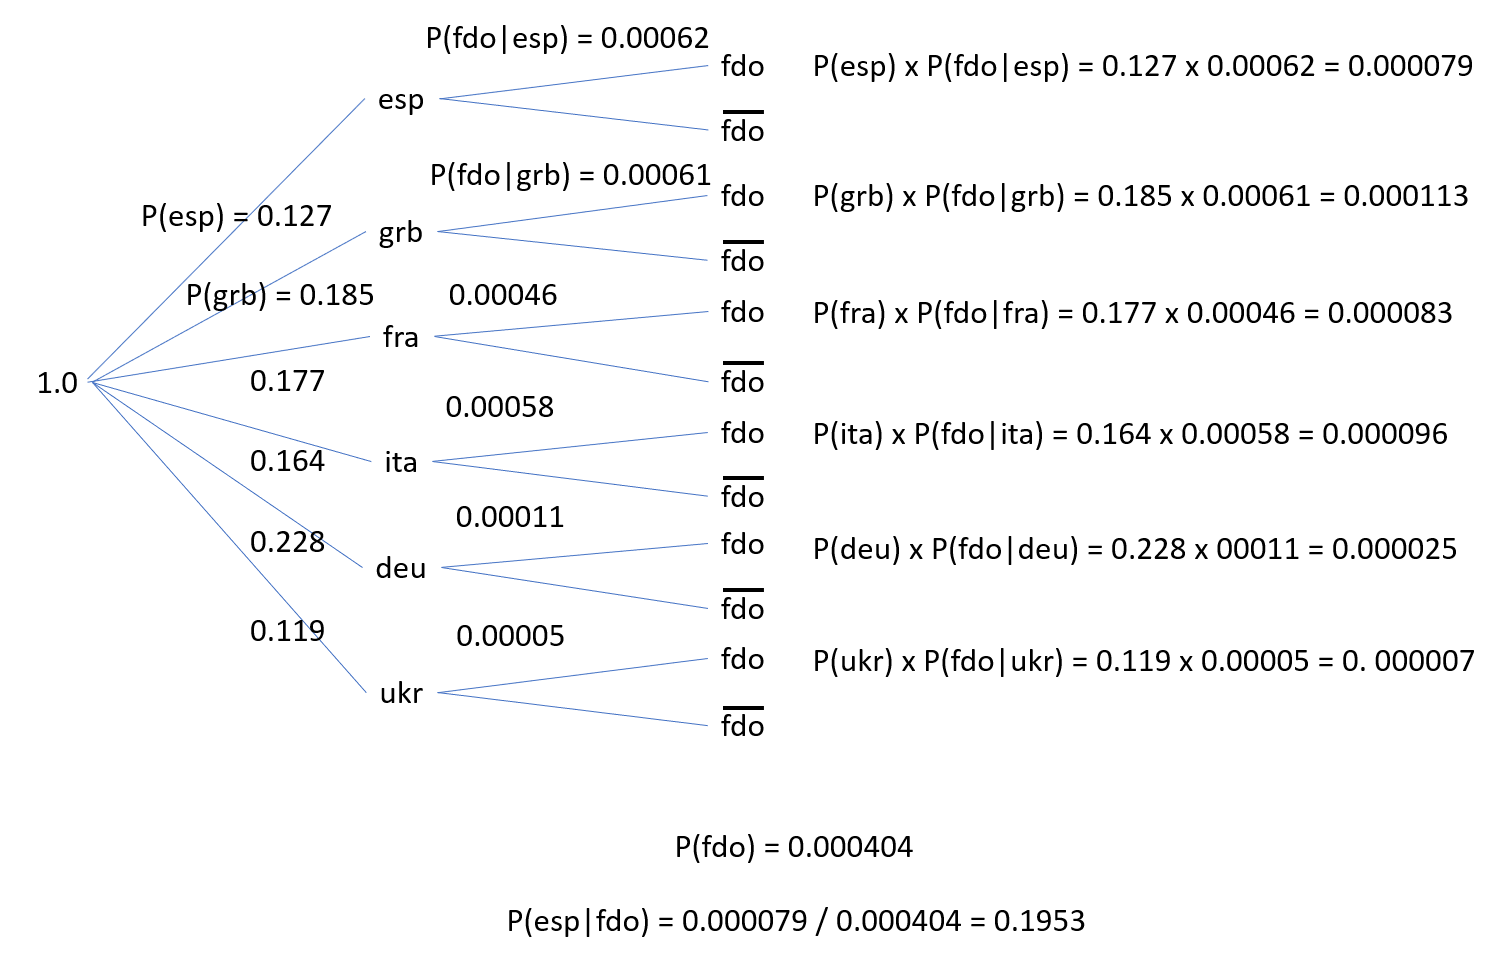


### **CONCLUSIONES** ###

Desde el punto de vista probabilístico, hemos comprobado empíricamente que se puede llegar al mismo resultado por diversos caminos, haciendo uso de herramientas poderosas como la regla de Laplace, Teorema de la Probabilidad Total, Torema de Bayes, probabilidad condicional y árbol de decisiones.   

Desde el punto de vista sustantivo, después del análisis de las medidas optadas por los gobiernos para contener el avance y las muertes por el COVID-19, se ha encontrado similitud en sus medidas, como: 
* Estado de emergencia (excepto Alemania)
* Cuarentena 
* Cierre de fronteras (Excepto UK)
* Control de los locales y restaurantes 
* Mascarilla obligatoria
* Reuniones sociales prohibidas o con aforo muy limitado.

Por lo tanto para explicar el impacto y resultados tan disímiles entre los países, pudieramos consierar variables exogenas de los gobiernos, como primer ingreso o caso detectado por país, en el análisis de las medidas podemos observar que Italia fue el primer país en decretar estado de emergencia, es decir, las muertes probablemente esten explicados tambièn por detecciòn de casos eficientes, sistemas de salud que responden de manera positiva ante estos casos, entre otras.